In [28]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
#from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
#drop NA values and check if it's a string
df = pd.read_csv('../full_photo_reviews_dc.csv', header=None,  names=['URL', 'Name', 'Title', 'Review'])
df.dropna(subset=['Name'], inplace=True)
df.dropna(subset=['Title'], inplace=True)
df.dropna(subset=['Review'], inplace=True)
df = df[df['Name'].apply(lambda x: x != "" and isinstance(x, str) )]
df = df[df['Title'].apply(lambda x: x != "" and isinstance(x, str) )]
df = df[df['Review'].apply(lambda x: x != "" and isinstance(x, str) )]
df

,URL,Name,Title,Review
0,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Excellent new contemporary hotel,I stayed here 3 nights for business. As a fema...
1,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Fabulous place to stay,"I loved the location at the Wharf. The room, a..."
2,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Don't stay on the 12th Floor!,First time to Washington and this area. We did...
3,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Suites are amazing,Excellent new Intercontinental Hotel in Washin...
4,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Weekend in DC,We arrived here from Scotland and were VERY im...
5,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Good location for are things,I booked a last minute business trip to DC. Lu...
6,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,The Wharf,I understand the Wharf is the latest IT thing ...
7,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Beautiful hotel (minor kinks),"Stayed there for a week with my wife, had supe..."
8,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Exquisite hotel with fabulous location.,The Willard is obviously a DC iconic landmark....
9,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Great hotel in newly revitalized area...,My husband and I stayed just one night for a q...


In [30]:
#create an id for each hotel based on hotel name for training purposes
nameMap = {}
nameCount = 0
def nameCategory(name):
    global nameCount
    name = name.strip().lower()
    if name not in nameMap:
        nameMap[name] = nameCount
        nameCount += 1
    return nameMap[name]
df['id'] = df['Name'].apply(nameCategory)
df['text'] = df['Title']  + " " + df['Review']

In [31]:
df

,URL,Name,Title,Review,id,text
0,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Excellent new contemporary hotel,I stayed here 3 nights for business. As a fema...,0,Excellent new contemporary hotel I stayed here...
1,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Fabulous place to stay,"I loved the location at the Wharf. The room, a...",0,Fabulous place to stay I loved the location at...
2,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Don't stay on the 12th Floor!,First time to Washington and this area. We did...,0,Don't stay on the 12th Floor! First time to Wa...
3,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Suites are amazing,Excellent new Intercontinental Hotel in Washin...,0,Suites are amazing Excellent new Intercontinen...
4,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Weekend in DC,We arrived here from Scotland and were VERY im...,0,Weekend in DC We arrived here from Scotland an...
5,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Good location for are things,I booked a last minute business trip to DC. Lu...,0,Good location for are things I booked a last m...
6,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,The Wharf,I understand the Wharf is the latest IT thing ...,0,The Wharf I understand the Wharf is the latest...
7,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Beautiful hotel (minor kinks),"Stayed there for a week with my wife, had supe...",0,Beautiful hotel (minor kinks) Stayed there fo...
8,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Exquisite hotel with fabulous location.,The Willard is obviously a DC iconic landmark....,0,Exquisite hotel with fabulous location. The W...
9,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Great hotel in newly revitalized area...,My husband and I stayed just one night for a q...,0,Great hotel in newly revitalized area... My hu...


In [32]:
df['Name'].describe()


count        7447
unique        135
top       No name
freq          323
Name: Name, dtype: object

In [33]:
#remove all with No Name
df = df[df['Name'] != 'No name']

In [34]:
df['Name'].describe()

count                    7124
unique                    134
top       Omni Shoreham Hotel
freq                      288
Name: Name, dtype: object

In [35]:
#remove punctuation, small words
def clean_text(text):
    # not isinstance(text, basestring) 
    #if text is None or isinstance(text, int) or isinstance(text, float):
    #    return ""
    ## Remove puncuation
    #text = unicode(text, "utf-8")
    try:
        text = text.translate(string.punctuation)
    except:
        print(text)
    
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [36]:
df['text'] = df['text'].map(lambda x: clean_text(x))

/Users/anastasia/Desktop/GWU/research/human_trafficking/tripadvisor_scraping/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
### Create sequence
#Embedding -- pre-trained word vectors -- to get context
vocabulary_size = 10000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])


In [38]:
from collections import defaultdict

#count number of symbols
max_word_count_text = 0
text_count = defaultdict(int)
reviews = df['text']
for sentence in reviews:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1

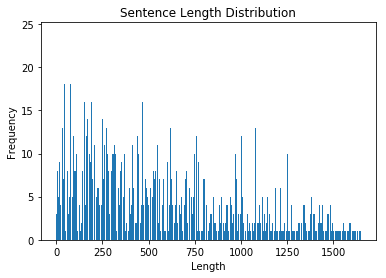

In [39]:
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [40]:
print('Max word text: %d' % max_word_count_text)

Max word text: 10302


In [41]:
maxlen = 100
data = pad_sequences(sequences, maxlen=maxlen)

In [42]:
labels = df['id']

In [43]:
# take 10% to test data
X_train, X_test, y_train, y_test = train_test_split(data, np.array(labels), test_size=0.1)

In [44]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
# take 20% to validation from train set
history = model.fit(X_train, y_train, validation_split=0.22, epochs=5)

Train on 5000 samples, validate on 1411 samples
Epoch 1/5
5000/5000 [==============================] - 13s 3ms/step - loss: -547.5386 - acc: 0.0000e+00 - val_loss: -670.3598 - val_acc: 0.0000e+00
Epoch 2/5
5000/5000 [==============================] - 11s 2ms/step - loss: -672.5646 - acc: 0.0000e+00 - val_loss: -670.3598 - val_acc: 0.0000e+00
Epoch 3/5
5000/5000 [==============================] - 11s 2ms/step - loss: -672.5646 - acc: 0.0000e+00 - val_loss: -670.3598 - val_acc: 0.0000e+00
Epoch 4/5
5000/5000 [==============================] - 14s 3ms/step - loss: -672.5646 - acc: 0.0000e+00 - val_loss: -670.3598 - val_acc: 0.0000e+00
Epoch 5/5
5000/5000 [==============================] - 11s 2ms/step - loss: -672.5646 - acc: 0.0000e+00 - val_loss: -670.3598 - val_acc: 0.0000e+00


In [46]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

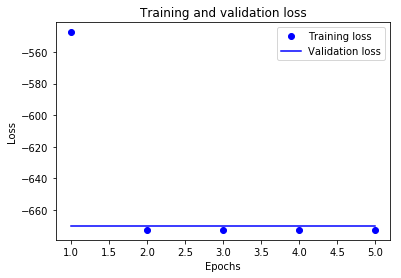

In [47]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

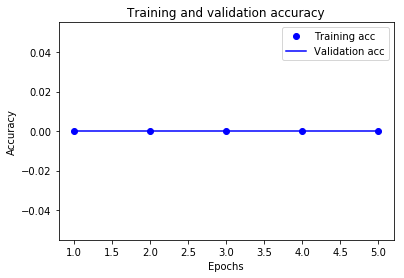

In [48]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
# Test data

loss, accuracy = model.evaluate(X_test, y_test)
print('loss     = ', loss)
print('accuracy = ', accuracy)

713/713 [==============================] - 0s 446us/step
loss     =  -688.8541361633557
accuracy =  0.0
